# Predicting Congestive Heart Failure

First "some" imports.

In [1]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pystout import pystout
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn.linear_model as skl_lm
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import metrics as skl_met
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import roc_curve, roc_auc_score
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
import warnings

C:\Users\OwenW\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\OwenW\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Introdution

Roughly 670,000 Americans are diagnosed with congestive heart failure each year. CHF is a progressive disease meaning that it does not appear in a singular event but rather gradually over time. This is good because it allows for the slowing or reversing of the disease before it becomes chronic. This means that doctors and practitioners, with the right tools, can prescribe medication or lifestyle changes to reduce the chances of CHF. A helpful tool for practitioners would be a way to predict an individual's chances of CHF. The goal of this paper is to find the machine learning model to best predict congestive heart failure. There is a lot of medical literature exploring medications and lifestyle changes so our goal is to not use the models for inference purposes. Rather we will explore prediction using strictly variables easily measured at a routine appointment. In the next section, we will explore the data and the data-cleaning process. Each model we explore will be tuned and then compared to find the best model for prediction. We will explore four model types, K-nearest neighbors, logistic regression, random forests, and naive Bayes.

### Data

All data used in this paper is from the National Health Interview Survey with samples being taken from 2015-2018. This is cross-sectional data with each row being a unique individual. Each individual is given a survey collecting information on health, healthcare access, and health behaviors. I want the model we develop to use only easily and routinely measured variables maximizing its practical use. The variables I chose were age, race, sex, poverty level, BMI, insurance coverage, diabetes, and smoking status. The outcome variable is a binary variable of having CHF or not. Each variable had a clear corresponding survey question with the exception of diabetes. Therefore we will use whether or not they are on insulin as a proxy due to that being insulin's main use. In the cell below we will read in the data and subset it for the variables of interest. 

In [2]:
df = pd.read_csv("MachineL.csv")
work=df[['AGE','SEX','RACENEW','POORYN','BMI','HINOTCOVE','CHEARTDIEV','INSULIN','SMOKESTATUS2']]

The next step was cleaning the data. This required some exploration of the data as well as reading the corresponding codebook for each variable. For some questions there was a chance it was not asked, the response was unclear, or they refused to answer. Therefore these responses needed to be dealt with. Handling of missing data is beyond the scope of this course so for our purposes we will assume the data is missing at random. This allows us to drop all rows with missing values without adding bias to our model. The dataset started with 351,921 unique rows and ended with 19,715 after cleaning. This is a significant loss in data but still an ample amount for analysis. 

In [3]:
work=work[work.POORYN!=9]

work=work[work.BMI!=0]

work=work[work.HINOTCOVE!=9]

work=work[work.CHEARTDIEV!=7]
work=work[work.CHEARTDIEV!=9]

work=work[work.INSULIN!=0]
work=work[work.INSULIN!=7]
work=work[work.INSULIN!=9]

work=work[work.SMOKESTATUS2!=0]

The next step was to make all the variables categorical before the analysis. Most variables only contain two options but race and smoking status have a spectrum of options. With our final working data set we then split it into an outcome vector and a predictor data frame. Using sklearn, we can make each into a test train split for analysis, which is the last step before fitting the models. 

In [4]:
work['SEX']=pd.Categorical(work.SEX)
work['RACENEW']=pd.Categorical(work.RACENEW)
work['HINOTCOVE']=pd.Categorical(work.HINOTCOVE)
work['POORYN']=pd.Categorical(work.POORYN)
work['INSULIN']=pd.Categorical(work.INSULIN)
work['SMOKESTATUS2']=pd.Categorical(work.SMOKESTATUS2)

x = work.drop(['CHEARTDIEV'], axis=1)
y = work["CHEARTDIEV"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)

### Models
#### Logistic

The first model we will explore is the traditional logistic regression. Logistic regression is typically used in situations where the interpretation of the coefficients is important. As stated in the introduction this is not the concern of this paper but the logistic regression is a good starting place and baseline model. Logistic regression also only does well with two categories. Below is the code that fits the model on the training data and provides an AUC score on the same training data. The max iterations had to be increased due to the size of the data. We can see below that the AUC score is actually quite good. All four models will be compared on the test dataset to find the best performer. 

In [5]:
log = LogisticRegression(random_state=3, max_iter=1000)
log.fit(x_train, y_train)
y_p=log.predict_proba(x_train)
roc=roc_auc_score(y_train,y_p[:,1])
print(roc)

0.7408915358574373


#### Naive Bayes

The next model we will explore is naive Bayes. Naive Bayes typically performs well in cases with categorical predictors. Our model is mostly categorical variables which would suggest that naive Bayes may perform well. The first cell below shows the standard naive Bayes fit on the full data set. In some further research, many suggest that to improve performance continuous variables should be changed to categorical. Therefore the second cell shows an attempt at that method of improvement. We made a cutoff for old and overweight and used those rather than the continuous variables. We did lose 0.35 performance in the AUC score. This would indicate that there is lots of valuable information in the continuous variables that are lost when you make them categorical. Therefore we will use the standard model and data in the comparison section.

In [6]:
naiveB = GaussianNB()
naiveB.fit(x_train, y_train)
y_p=naiveB.predict_proba(x_train)
roc=roc_auc_score(y_train,y_p[:,1])
print(roc)

0.7194986523214046


In [7]:
# Making a copy of data set
sub=work[['AGE','SEX','RACENEW','POORYN','BMI','HINOTCOVE','CHEARTDIEV','INSULIN','SMOKESTATUS2']]
# Making new variables
sub['old']=np.where(sub.AGE>=45,1,0)
sub['overwe']=np.where(sub.BMI>=25,1,0)
# Sub setting and preforming analysis
sub=sub[['SEX','RACENEW','POORYN','HINOTCOVE','CHEARTDIEV','INSULIN','SMOKESTATUS2','old','overwe']]
sx = sub.drop(['CHEARTDIEV'], axis=1)
sy = sub["CHEARTDIEV"]
sx_train, sx_test, sy_train, sy_test = train_test_split(sx, sy, test_size=0.25, random_state=123)
naiveB = GaussianNB()
naiveB.fit(sx_train, sy_train)
y_p=naiveB.predict_proba(sx_train)
roc=roc_auc_score(sy_train,y_p[:,1])
print(roc)

0.6864651476767735


#### K-Nearest Neighbors

The third model used will be K-nearest neighbors. This performs well in situations with a low amount of input variables and a large amount of data. This also requires parameter tuning to find the optimal number of neighbors. The first cell is a for loop that is using cross validation on the training data set to find the number of neighbors with the highest AUC score. 

In [8]:
folds = 8
kfold_roc = []

for j in range(1,120,5):
    nehbrs_model = neighbors.KNeighborsClassifier(n_neighbors=j)
    kf_10 = KFold(n_splits=folds, shuffle=True, random_state=1)
    roc = cross_val_score(nehbrs_model, x_train, y_train, cv=kf_10, scoring='roc_auc').mean() 
    kfold_roc.append(roc) 
    

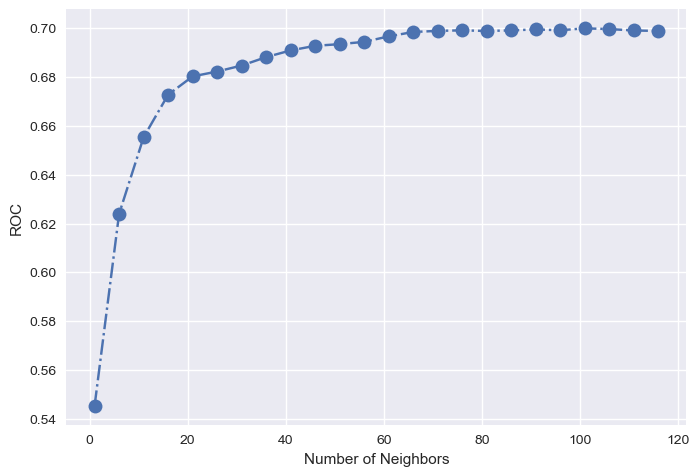

In [9]:
plt.plot(range(1,120,5), kfold_roc, '.-.', markersize=20)
plt.xlabel("Number of Neighbors") 
plt.ylabel("ROC")
plt.show()

The graph above shows that somewhere around 100 has the highest ROC score therefore we can run the same loop from 95-105 to find the highest ROC score. The graph below shows that 101 is the best number of neighbors and therefore will be used during model comparison.

In [10]:
folds = 8
kfold_roc = []
for j in range(95,105):
    nehbrs_model = neighbors.KNeighborsClassifier(n_neighbors=j)
    kf_10 = KFold(n_splits=folds, shuffle=True, random_state=1)
    roc = cross_val_score(nehbrs_model, x_train, y_train, cv=kf_10, scoring='roc_auc').mean() 
    kfold_roc.append(roc) 
  

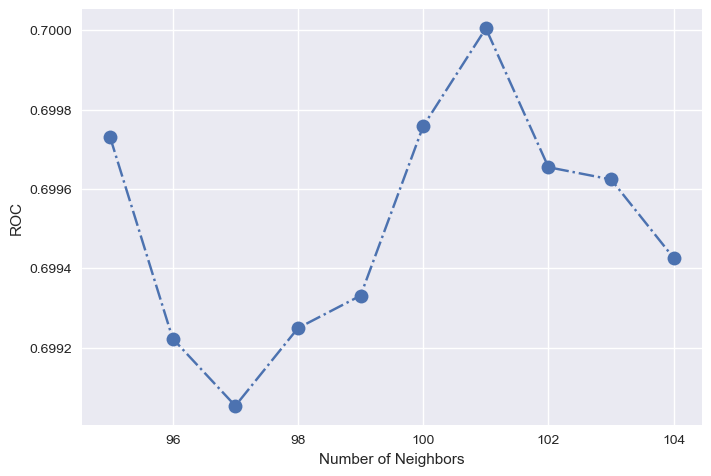

In [11]:
plt.plot(range(95,105), kfold_roc, '.-.', markersize=20)
plt.xlabel("Number of Neighbors") 
plt.ylabel("ROC")
plt.show()

#### Random Forest

Lastly, we will look at random forests which typically perform well with a combination of continuous and binary variables. Random forests excel with an output variable containing multiple categories rather than strictly binary. We again will use cross-validation to determine the number of maximum features that produce the best ROC score. The graph below shows 6 is the optimal amount of maximum features for the final model.

In [12]:
folds = 10
kfold_roc = []

for j in range(1,8):
    tre = ensemble.RandomForestClassifier(n_estimators=100, max_features=j, random_state = 11850)
    kf_10 = KFold(n_splits=folds, shuffle=True, random_state=1)
    roc = cross_val_score(tre, x_train, y_train, cv=kf_10, scoring='roc_auc').mean() 
    kfold_roc.append(roc) 

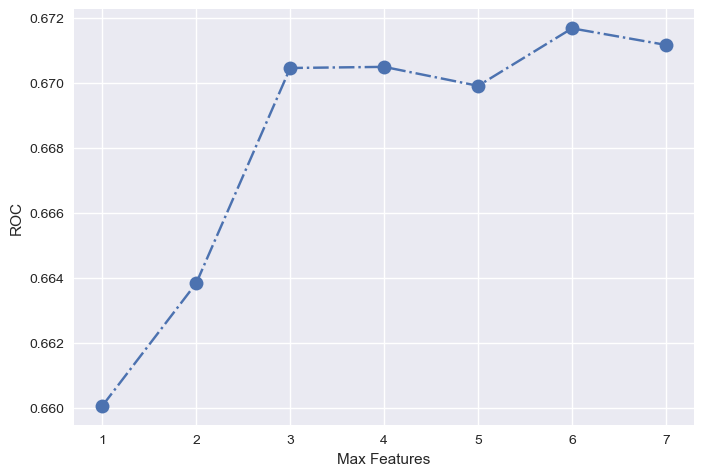

In [13]:
plt.plot(range(1,8), kfold_roc, '.-.', markersize=20)
plt.xlabel("Max Features") 
plt.ylabel("ROC")
plt.show()

### Comparing Models

Now that all models have been fit we can compare all models both visually and using their AUC scores. Below we run all four of the optimized models and train them on the same X and Y training data. We then use the fitted models to predict the probabilities on the X testing data. Using these probabilities we can use SKLearn to compare the models using a ROC curve. The figure below shows each model's ROC curve. There is lots of overlap between the models but logistic regression appears to perform the best. The random forest seems to fall behind all other models. 

In [14]:
log_final = LogisticRegression(random_state=3, max_iter=1000)
naiveB_final = GaussianNB()
nehbrs_final = neighbors.KNeighborsClassifier(n_neighbors=101)
tre_final = ensemble.RandomForestClassifier(n_estimators=100, max_features=6, random_state = 11850)

log_final.fit(x_train, y_train)
naiveB_final.fit(x_train, y_train)
nehbrs_final.fit(x_train, y_train)
tre_final.fit(x_train, y_train)

log_pro = log_final.predict_proba(x_test)
nai_pro = naiveB_final.predict_proba(x_test)
nei_pro = nehbrs_final.predict_proba(x_test)
tre_pro = tre_final.predict_proba(x_test)

In [15]:
y_test=y_test-1
log_fpr, log_tpr, threshold = roc_curve(y_test, log_pro[:,1])
nai_fpr, nai_tpr, threshold = roc_curve(y_test, nai_pro[:,1])
nei_fpr, nei_tpr, threshold = roc_curve(y_test, nei_pro[:,1])
tre_fpr, tre_tpr, threshold = roc_curve(y_test, tre_pro[:,1])

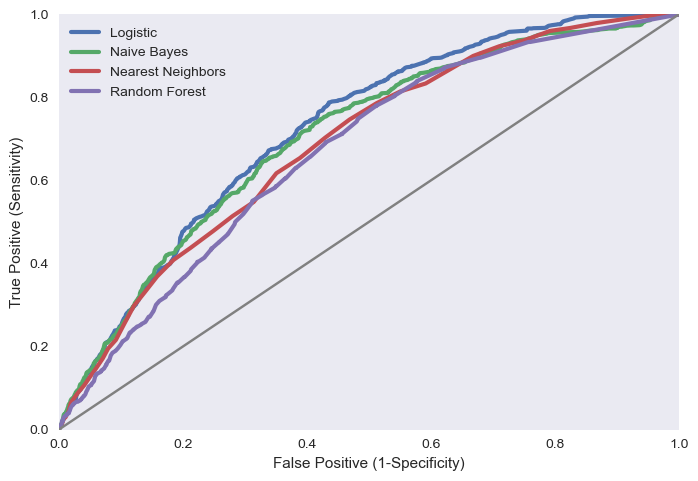

In [16]:
plt.figure(dpi=100)
sn.lineplot(x=log_fpr, y=log_tpr,  label='Logistic',ci=None, linewidth=3)
sn.lineplot(x=nai_fpr, y=nai_tpr,  label='Naive Bayes',ci=None, linewidth=3)
sn.lineplot(x=nei_fpr, y=nei_tpr,  label='Nearest Neighbors',ci=None, linewidth=3)
sn.lineplot(x=tre_fpr, y=tre_tpr,  label='Random Forest',ci=None, linewidth=3)
plt.axline([0, 0], [1, 1],color='grey')
plt.xlabel("False Positive (1-Specificity)")
plt.ylabel("True Positive (Sensitivity)")
plt.xlim(0,1); plt.ylim(0,1)
plt.grid()
plt.show()

To better understand the rank in performance between the models we can compare their AUC scores. Below is code that calculates the score and graphs the results in a bar graph. Logistic is the top performing model, followed by naive Bayes with KNN and random forests performing the worst. As we discussed earlier logistic regression does well with two categories. Therefore it would make sense that logistic regression would hold its own against the more complex models because the outcome is binary. Nearest neighbors and random forests perform better in situations with multiple categorical outcomes. The logistic regression model would be the best model to recommend for practical use. As expected the logistic regression has a lower AUC score on the test data than it did on the training data but not by a significant amount. This would indicate that the model has low bias. The random forest has the lowest difference between the AUC score on the training and test sets at about 0.003. All other models have about a 0.2 decrease in AUC performance. 

In [17]:
log_roc = roc_auc_score(y_test, log_pro[:,1])
nai_roc = roc_auc_score(y_test, nai_pro[:,1])
nei_roc = roc_auc_score(y_test, nei_pro[:,1])
tre_roc = roc_auc_score(y_test, tre_pro[:,1])
print('Logistic AUC',log_roc)
print('Naive Bayes AUC',nai_roc)
print('KNN AUC',nei_roc)
print('Random Forest AUC',tre_roc)

Logistic AUC 0.7228141915744881
Naive Bayes AUC 0.7052744244320462
KNN AUC 0.688325626791079
Random Forest AUC 0.66971190453117


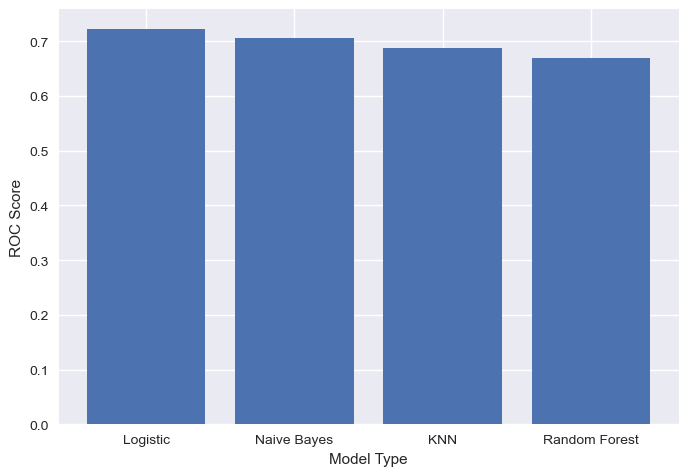

In [18]:
plt.bar(x=range(4),height=[log_roc, nai_roc, nei_roc,tre_roc])
plt.xticks(range(4),["Logistic", "Naive Bayes", "KNN", "Random Forest"])
plt.ylabel('ROC Score'); plt.xlabel('Model Type')
plt.show()

### Conclusion

This paper has explored different models for predicting congestive heart failure using strictly variables collected at a routine visit. We have found that the logistic regression model performs the best in prediction with an AUC score of 0.72. This makes it a fairly good model but not great. Each model tested has its strengths and weaknesses but the nature of the data allowed logistic regression to outperform the more complex modeling. Models of this nature would allow physicians to use machine learning as a supplement to their own medical knowledge. Models like this can be a tool but should not be the sole decider in treatments. For example, maybe a doctor knows an individual has a family history of congestive heart failure. The model was not trained on that data therefore it can not be accounted for in the model prediction. Physicians and doctors must use their pre-existing knowledge to supplement any results drawn from the model. The beautiful part about models that use variables collected on standard visits is that the outcome variable can be changed to any adverse outcome and the model building process would be near identical. 